In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteo_imp.kalman.results import *
from meteo_imp.data import *
from meteo_imp.utils import *
import pandas as pd
import numpy as np
from pyprojroot import here
import torch
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import SVG, Image
import altair as alt
from functools import partial

import io
from contextlib import redirect_stderr
from fastai.vision.data import get_grid

In [ ]:
import vl_convert as vlc
from pyprojroot import here
base_path_img = here("manuscript/Master Thesis - Evaluation of Kalman filter for meteorological time series imputation for Eddy Covariance applications - Simone Massaro/images/")
base_path_tbl = here("manuscript/Master Thesis - Evaluation of Kalman filter for meteorological time series imputation for Eddy Covariance applications - Simone Massaro/tables/")

base_path_img.mkdir(exist_ok=True), base_path_tbl.mkdir(exist_ok=True)

def save_show_plot(plot, path):
    with redirect_stderr(io.StringIO()):
        plot.save(base_path_img / (path + ".pdf"))
    # render to image for displaying in notebook
    png_data = vlc.vegalite_to_png(vl_spec=plot.to_json(), scale=1)
    return Image(png_data)

plotting additional figure for introduction

In [ ]:
hai = pd.read_parquet(hai_big_path).reindex(columns=var_type.categories)
hai_era = pd.read_parquet(hai_era_big_path)

In [ ]:
models_var = pd.DataFrame.from_records([
    {'var': 'TA',    'model': l_model("TA_specialized_gap_6-336_v3_0.pickle",base_path)},
    {'var': 'SW_IN', 'model': l_model("SW_IN_specialized_gap_6-336_v2_0.pickle",base_path)},
    {'var': 'LW_IN', 'model': l_model("LW_IN_specialized_gap_6-336_v1.pickle",base_path)},
    {'var': 'VPD',   'model': l_model("VPD_specialized_gap_6-336_v2_0.pickle",base_path)},
    {'var': 'WS',    'model': l_model("WS_specialized_gap_6-336_v1.pickle",base_path)},
    {'var': 'PA',    'model': l_model("PA_specialized_gap_6-336_v3_0.pickle",base_path)},
    {'var': 'P',     'model': l_model("1_gap_varying_6-336_v3.pickle",base_path)},
    {'var': 'TS',    'model': l_model("TS_specialized_gap_6-336_v2_0.pickle",base_path)},
    {'var': 'SWC',   'model': l_model("SWC_specialized_gap_6-336_v2_1.pickle",base_path)},
])

In [ ]:
reset_seed()
comp_Av = ImpComparison(models = models_var, df = hai, control = hai_era, block_len = 48+100, time_series=True, rmse=False)
results_ts = comp_Av.compare(gap_len = [48], var=list(hai.columns), n_rep=1) 

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

In [ ]:
res_ts = results_ts.query("method != 'Kalman Filter'")
res_ts_plot = pd.concat([unnest_predictions(row, ctx_len=72) for _,row in res_ts.iterrows()])

In [ ]:
from meteo_imp.kalman.results import _plot_timeseries, _get_labels

In [ ]:
scale_sota = alt.Scale(domain=["ERA-I", "MDS"], range=list(sns.color_palette('Dark2', 3).as_hex())[1:])

In [ ]:
from fastcore.basics import *
from typing import Callable

In [ ]:
@patch
def pipe(self: alt.Chart, f: Callable): return f(self)

In [ ]:
class 

In [ ]:
font_size = 20
legend_font_size = 22
title_font_size = 22

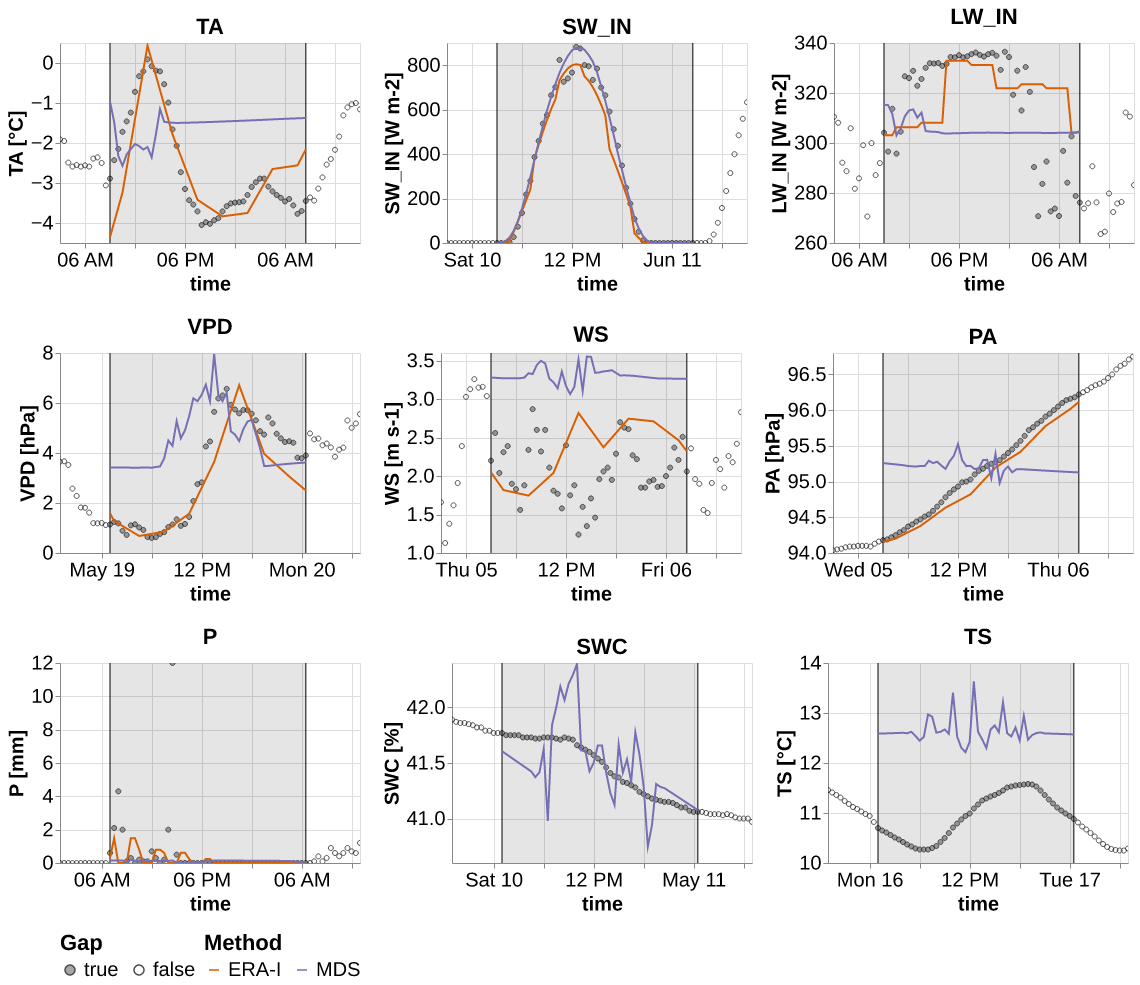

In [ ]:
p = (facet_wrap(res_ts_plot, partial(_plot_timeseries, scale_color=scale_sota, err_band = False), col="var",
                y_labels = _get_labels(res_ts_plot, 'mean', None),
               )
            .configure_legend(orient="bottom", labelFontSize=font_size, titleFontSize=legend_font_size)
            .configure_axis(labelFontSize=font_size, titleFontSize=font_size )
            .configure_title(fontSize=title_font_size)
    )
save_show_plot(p, "timeseries_sota")

## Correlation

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
import statsmodels.api as sm

In [ ]:
def auto_corr_df(data, nlags=96):
    autocorr = {}
    for col in data.columns:
        autocorr[col] = sm.tsa.acf(data[col], nlags=nlags)
    return pd.DataFrame(autocorr)

In [ ]:
auto_corr = auto_corr_df(hai).reset_index(names="gap_len").melt(id_vars="gap_len")
auto_corr.gap_len = auto_corr.gap_len / 2

In [ ]:
auto_corr

,gap_len,variable,value
0,0.0,TA,1.000000
1,0.5,TA,0.998595
2,1.0,TA,0.995814
3,1.5,TA,0.992141
4,2.0,TA,0.987630
...,...,...,...
868,46.0,TS,0.959680
869,46.5,TS,0.961116
870,47.0,TS,0.962085
871,47.5,TS,0.962551


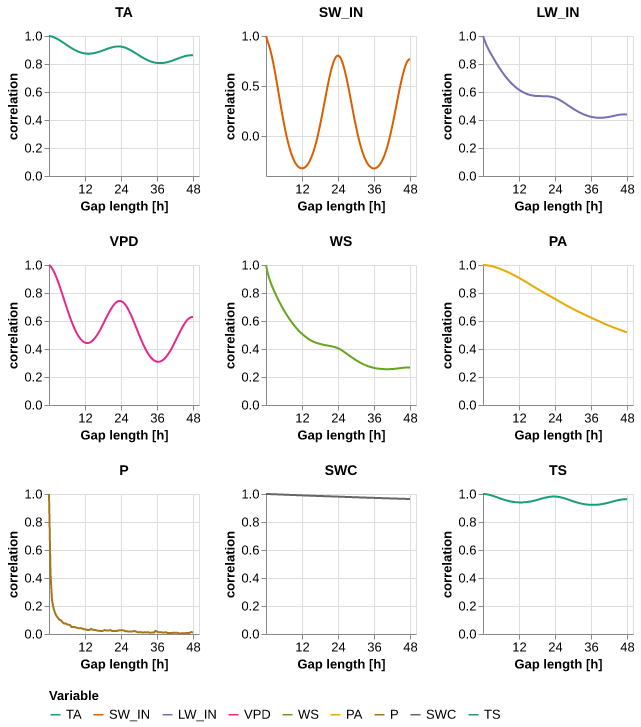

In [ ]:
p = (alt.Chart(auto_corr).mark_line().encode(
    x = alt.X('gap_len', title="Gap length [h]", axis = alt.Axis(values= [12, 24, 36, 48])),
    y = alt.Y("value", title="correlation"),
    color=alt.Color("variable", scale=meteo_scale, title="Variable"),
    facet =alt.Facet('variable', columns=3, sort = meteo_scale.domain, title=None,
                     header = alt.Header(labelFontWeight="bold", labelFontSize=14))
)
    .properties(height=140, width=150)
    .resolve_scale(y='independent', x = 'independent')
    .configure_legend(orient="bottom", labelFontSize=13, titleFontSize=13)
    .configure_axis(labelFontSize=13, titleFontSize=13 )
    .configure_title(fontSize=16))

save_show_plot(p, "temporal_autocorrelation")

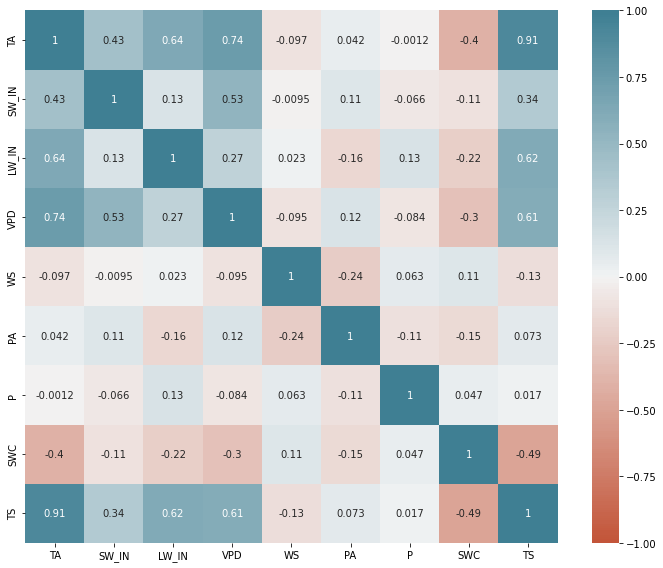

In [ ]:
axes = get_grid(1,1,1, figsize=(10,8))
sns.heatmap(hai.corr(), annot=True,     vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200), ax=axes[0], square=True, cbar=True)
# axes[0].set(xlabel="Variable", ylabel="Variable", title="Inter-variable Correlation");
plt.tight_layout()
plt.savefig(base_path_img / "correlation.pdf")